In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [12]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.1 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

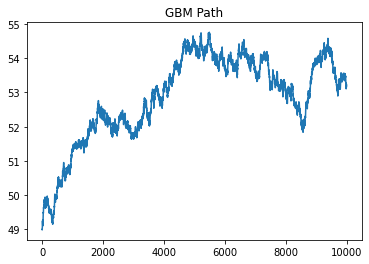

In [13]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
#np.random.seed(seed=1)
M = 10000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [14]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)
option_value_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type)*option_exposure

The time of execution of is: 0.0030019283294677734
Option price is [2.40052732 2.39299409 2.42520267 ... 3.17621936 3.18443452 3.22792269]


c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)*np.exp(-q*T)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma*np.exp(-q*T)/(2*np.sqrt(T)) + q*S*norm.cdf(d1)*np.exp(-q*T)


In [15]:
summary_df = pd.DataFrame(list(zip(S, option_value_array, delta_array)), columns=['Stock_Price', 'Option_Value', 'Delta'])
summary_df

,Stock_Price,Option_Value,Delta
0,49.000000,-240052.732327,0.521605
1,48.985862,-239299.408831,0.520670
2,49.047800,-242520.266991,0.524721
3,49.037605,-241969.070106,0.524046
4,49.038066,-241976.663014,0.524068
...,...,...,...
9995,53.196815,-319720.001473,1.000000
9996,53.184783,-318507.113807,1.000000
9997,53.176027,-317621.936256,1.000000
9998,53.184338,-318443.452481,1.000000


In [16]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Share_PnL'] = summary_df['Shares_Held'].shift()*(summary_df['Stock_Price'] - summary_df['Stock_Price'].shift())

summary_df['Interest_Cost'] = (summary_df['Shares_Held']*summary_df['Stock_Price']).shift()*r*dt + summary_df['Option_Value'].shift()*r*dt
summary_df['Option_PnL'] = summary_df['Option_Value'] - summary_df['Option_Value'].shift()
summary_df['Portfolio_PnL'] = summary_df['Share_PnL'] - summary_df['Interest_Cost'] 
summary_df['Hedged_Portfolio_PnL'] = summary_df['Portfolio_PnL'] + summary_df['Option_PnL'] 

summary_df['Portfolio_Value'] = -summary_df['Option_Value']
for i in range(1, len(summary_df)):
    summary_df['Portfolio_Value'].iloc[i] = summary_df['Portfolio_Value'].iloc[i-1] + summary_df['Share_PnL'].iloc[i] + (summary_df['Portfolio_Value'].iloc[i-1] - summary_df['Shares_Held'].iloc[i-1]*summary_df['Stock_Price'].iloc[i-1])*r*dt 
summary_df['Portfolio_PnL2'] = summary_df['Portfolio_Value'] - summary_df['Portfolio_Value'].shift()
summary_df['Hedged_Portfolio_PnL2'] = summary_df['Portfolio_PnL2'] + summary_df['Option_PnL'] 

summary_df

,Stock_Price,Option_Value,Delta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Share_PnL,Interest_Cost,Option_PnL,Portfolio_PnL,Hedged_Portfolio_PnL,Portfolio_Value,Portfolio_PnL2,Hedged_Portfolio_PnL2
0,49.000000,-240052.732327,0.521605,52160.466107,52160.466107,2.555863e+06,2.555863e+06,NaN,NaN,NaN,NaN,NaN,240052.732327,NaN,NaN
1,48.985862,-239299.408831,0.520670,52067.021255,-93.444851,-4.577477e+03,2.551285e+06,-737.428442,4.453926,753.323496,-741.882369,11.441127,239310.849958,-741.882369,11.441127
2,49.047800,-242520.266991,0.524721,52472.058944,405.037689,1.986621e+04,2.571152e+06,3224.885187,4.445153,-3220.858160,3220.440034,-0.418126,242531.290015,3220.440056,-0.418104
3,49.037605,-241969.070106,0.524046,52404.571509,-67.487435,-3.309422e+03,2.567842e+06,-534.946792,4.483369,551.196885,-539.430161,11.766723,241991.859875,-539.430140,11.766745
4,49.038066,-241976.663014,0.524068,52406.848920,2.277411,1.116798e+02,2.567954e+06,24.183429,4.477035,-7.592908,19.706393,12.113486,242011.566312,19.706437,12.113530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,53.196815,-319720.001473,1.000000,100000.000000,-0.000000,-0.000000e+00,5.079685e+06,1041.165703,9.616254,-1031.549440,1031.549449,0.000009,406138.488427,1031.715655,0.166215
9996,53.184783,-318507.113807,1.000000,100000.000000,-0.000000,-0.000000e+00,5.079685e+06,-1203.271384,9.616272,1212.887666,-1212.887656,0.000009,404925.766977,-1212.721450,0.166215
9997,53.176027,-317621.936256,1.000000,100000.000000,-0.000000,-0.000000e+00,5.079685e+06,-875.561251,9.616291,885.177551,-885.177542,0.000009,404040.755641,-885.011336,0.166216
9998,53.184338,-318443.452481,1.000000,100000.000000,-0.000000,-0.000000e+00,5.079685e+06,831.132544,9.616309,-821.516225,821.516235,0.000009,404862.438082,821.682441,0.166216


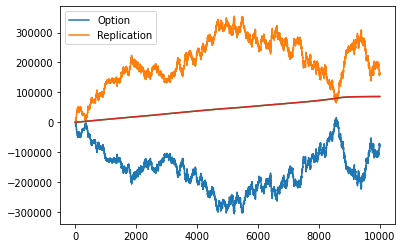

In [17]:
plt.plot(summary_df['Option_PnL'].cumsum(), label='Option')
plt.plot(summary_df['Portfolio_PnL'].cumsum(), label='Replication')
plt.plot(summary_df['Hedged_Portfolio_PnL'].cumsum())
plt.plot(summary_df['Hedged_Portfolio_PnL2'].cumsum())

plt.legend()
plt.show()

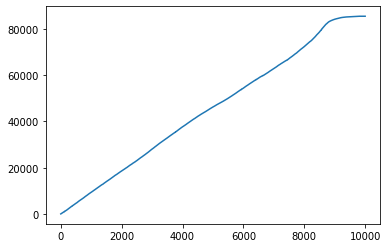

In [18]:
plt.plot(summary_df['Hedged_Portfolio_PnL'].cumsum())


In [19]:
hedging_pnl = summary_df['Portfolio_PnL'].cumsum().iloc[-1] + summary_df['Option_PnL'].cumsum().iloc[-1]
print(f'Hedging Error: ${hedging_pnl}')


Hedging Error: $85534.35448975241


In [20]:
hedging_pnl = summary_df['Portfolio_PnL2'].cumsum().iloc[-1] + summary_df['Option_PnL'].cumsum().iloc[-1]
print(f'Hedging Error2: ${hedging_pnl}')

Hedging Error2: $86419.15181749291
